In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [ ]:
x = torch.randn(10, 50)
W1 = nn.Parameter(torch.randn(128, 50))

print(W1)
print('\n\n')

# its shape
print(W1.shape)
print(W1.t().shape)
print('\n\n')

# compute an output
y = x@W1.t()
print(y.shape)

Parameter containing:
tensor([[ 0.0557,  2.2564, -0.2931,  ..., -0.2396,  0.1695, -0.6065],
        [-0.9168, -1.1357,  0.8367,  ..., -0.2674, -0.4616,  0.3081],
        [-2.0763, -0.5037, -0.2351,  ...,  0.4252, -1.2178,  1.2015],
        ...,
        [-1.0051,  2.1116, -1.0737,  ..., -0.7598, -0.6147,  0.4965],
        [-0.4727,  1.3270, -1.1028,  ..., -0.9885, -0.6444,  0.7787],
        [ 1.3899, -1.1450, -2.2706,  ..., -1.6503, -0.1409, -0.3048]],
       requires_grad=True)



torch.Size([128, 50])
torch.Size([50, 128])



torch.Size([10, 128])


In [ ]:
W2 = nn.Linear(128, 50)

print(W2)
print('\n\n')

# its size and the size of its transpose
print(W2.weight.shape)
print(W2.weight.t().shape)
print('\n\n')

y = x@(W2.weight)
print(y.shape)


Linear(in_features=128, out_features=50, bias=True)



torch.Size([50, 128])
torch.Size([128, 50])



torch.Size([10, 128])


In [ ]:
dir(nn.Linear)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__constants__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_call_impl',
 '_compiled_call_impl',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_load_from_state_dict',
 '_maybe_warn_non_full_backward_hook',
 '_named_members',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_version',
 '_wrapped_call_impl',
 'add_module',
 'apply',
 'bfloat16',
 'buffers',
 'call_super_init',
 'children',
 'compile',
 'cpu',
 'cuda',
 'double',
 'dump_p

In [ ]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# don't need labels!
data = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# convert to tensor
dataT = torch.tensor( dataNorm ).float()

In [ ]:
def createTheMNISTAE():

    class aenet(nn.Module):
        def __init__(self):
            super().__init__()

            # input layer
            self.input = nn.Linear(784, 128)

            # encoder layer
            self.enc = nn.Parameter(torch.randn(50, 128))

            # latent layer not used

            # decoder layer
            self.dec = nn.Linear(128, 784)

        def forward(self, x):

            # forward prop in first stage
            x = F.relu(self.input(x))

            # a Parameter type is not a linear type, so we implement the multiplication directly
            x = x.t() # need to transpose the input matrix due to multisample input matrices
            x = F.relu(self.enc@x)

            # same for the decoding layer but reversed
            x = F.relu(self.enc.t()@x)
            x = x.t()

            # notmal final stage
            y = torch.sigmoid(self.dec(x))

            return y

    net = aenet()

    lossfun = nn.MSELoss()

    optimizer = torch.optim.Adam(net.parameters(), lr = .001)

    return net, lossfun, optimizer

In [ ]:
net, lossfun, optimizer = createTheMNISTAE()

X = dataT[:5, :]
yHat = net(X)

print(X.shape)
print(yHat.shape)

torch.Size([5, 784])
torch.Size([5, 784])


In [ ]:
def function2trainTheModel():

  # number of epochs
  numepochs = 10000

  # create a new model
  net,lossfun,optimizer = createTheMNISTAE()

  # initialize losses
  losses = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # select a random set of images
    randomidx = np.random.choice(dataT.shape[0],size=32)
    X = dataT[randomidx,:]

    # forward pass and loss
    yHat = net(X)
    loss = lossfun(yHat,X)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # losses in this epoch
    losses[epochi] = loss.item()
  # end epochs

  # function output
  return losses,net

Final loss: 0.3207


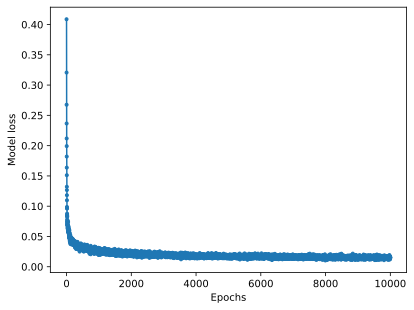

In [ ]:
losses, net = function2trainTheModel()
print(f'Final loss: {losses[1]:.4f}')

# visualize the losses
plt.plot(losses, '.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.show()

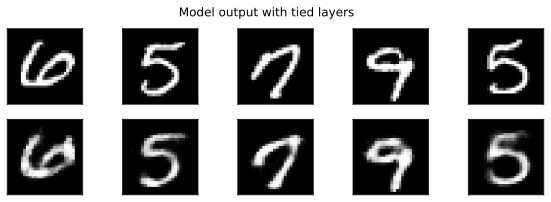

In [ ]:
# Visualization of inputs and outputs
X = dataT[:5,:]
yHat = net(X)


# let's see what the model did!
fig,axs = plt.subplots(2,5,figsize=(10,3))

for i in range(5):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(yHat[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])

plt.suptitle('Model output with tied layers')
plt.show()

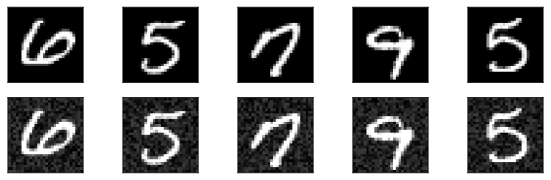

In [ ]:
# grab a small set of images
X = dataT[:10,:]

# add noise
Xnoise = X + torch.rand_like(X)/4

# clip at 1
Xnoise[Xnoise>1] = 1


# show the noisy images
fig,axs = plt.subplots(2,5,figsize=(10,3))

for i in range(5):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(Xnoise[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])

plt.show()

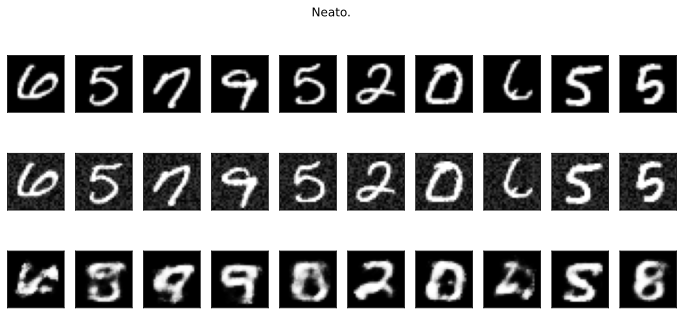

In [ ]:
# run through the model
Y = net(Xnoise)


# show the noisy images
fig,axs = plt.subplots(3,10,figsize=(12,5))

for i in range(10):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(Xnoise[i,:].view(28,28).detach() ,cmap='gray')
  axs[2,i].imshow(Y[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  axs[2,i].set_xticks([]), axs[2,i].set_yticks([])

plt.suptitle('Neato.')
plt.show()